In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
from libs import exploring as explore
from libs import visualising as visualize
from libs import cleansing as cleanse

In [2]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("./data/cleanse/columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import,
                            index_col='code')

In [3]:
data_summary_string = "The dataset now comprises {} entries, of which we have {} features."
data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1])

'The dataset now comprises 691256 entries, of which we have 20 features.'

# Explore the data

In [4]:
food_facts_pd.head(10)

,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels_en,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,,
0000000000017,1529059080,2018-06-15T10:38:00Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,1569.0,NaN,NaN,NaN
0000000000031,1539464774,2018-10-13T21:06:14Z,Cacao,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
0000000000123,1535737982,2018-08-31T17:53:02Z,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,88.0,NaN,NaN,NaN
0000000000291,1534239669,2018-08-14T09:41:09Z,Mendiants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
0000000000949,1523440813,2018-04-11T10:00:13Z,Salade de carottes râpées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,134.0,NaN,NaN,NaN
0000000000970,1520506368,2018-03-08T10:52:48Z,Fromage blanc aux myrtilles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,540.0,NaN,NaN,NaN
0000000001001,1537766416,2018-09-24T05:20:16Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
0000000001007,1538127563,2018-09-28T09:39:23Z,Vainilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
0000000001137,1539781575,2018-10-17T13:06:15Z,Baguette parisien,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,929.0,NaN,NaN,NaN


## Display number of NaN entries per column

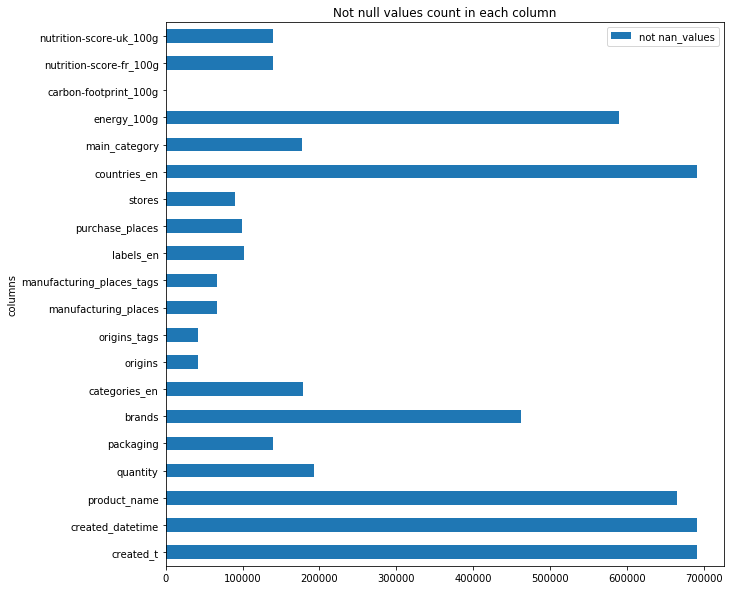

In [5]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
plt.title("Not null values count in each column")
plt.show()

We see that there are many NaN entries in this data set. For our analysis, we can only use entries that have at least a product name, country tag, manufacturing and purchase place, and a created date tag. Unfortunately, we have to drop all columns, that lack those data.

In [6]:
no_rows_inital = food_facts_pd.shape[0]

# Drop entries with missing entries in of our main-features
essential_columns = ['created_t', 'product_name', 'countries_en', 'categories_en', 'manufacturing_places', 'purchase_places']
food_facts_pd = food_facts_pd.dropna(subset=essential_columns, )

no_rows_reduced_nan = food_facts_pd.shape[0]

# Also drop duplicated values (indentify based on index (barcode))
food_facts_pd = food_facts_pd.drop_duplicates()

no_rows_reduced_duplicates = food_facts_pd.shape[0]

print("{} entries were dropped, of which {} were duplicates."\
      .format(no_rows_inital-no_rows_reduced_duplicates, no_rows_reduced_nan-no_rows_reduced_duplicates))
print(data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1]))

638808 entries were dropped, of which 2 were duplicates.
The dataset now comprises 52448 entries, of which we have 20 features.


Puhh, that was though. From now on, we are going to rescue the data and enrich wherever we can.

In [7]:
# Replace NaNs with emptry string
food_facts_pd = food_facts_pd.fillna("")

In [8]:
# Next lets look at the data types:

In [9]:
food_facts_pd.dtypes

created_t                    object
created_datetime             object
product_name                 object
quantity                     object
packaging                    object
brands                       object
categories_en                object
origins                      object
origins_tags                 object
manufacturing_places         object
manufacturing_places_tags    object
labels_en                    object
purchase_places              object
stores                       object
countries_en                 object
main_category                object
energy_100g                  object
carbon-footprint_100g        object
nutrition-score-fr_100g      object
nutrition-score-uk_100g      object
dtype: object

In [10]:
#

Another thing that we are not really keen of are the language indicators, so we are going to remove those abbreviations.

In [11]:
def remove_language_indicator(row_str):
    tags = [tag if len(tag.split(':'))==1 else tag.split(':')[1] for tag in row_str.split(',')]
    return ",".join(tags)

In [12]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(remove_language_indicator)
food_facts_pd.main_category = food_facts_pd.main_category.apply(remove_language_indicator)
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(remove_language_indicator)
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(remove_language_indicator)

The next issue we are going to tackel are redudant columns. Especially here, these are similarly named columns ending with "_en", "_tags". We are handling this, by only importing columns that end with "_en" if we have the choice.

In [13]:
food_facts_pd

,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels_en,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,,
0000000020114,1502444009,2017-08-11T09:33:29Z,Naturablue original,250 ml,"bocal,plastique",Natura4Ever,Dietary supplements,,,France,france,Made in France,France,,France,dietary-supplements,0,,,
0000000274722,1514659309,2017-12-30T18:41:49Z,Blanquette de Volaille et son Riz,,"carton,plastique",Comme J’aime,"Meals,Meat-based products,Meals with meat,Poul...",France,france,France,france,"Viande Française,Made in France",France,Comme J'aime,France,meals,450,,0,0
0000000394710,1484497370,2017-01-15T16:22:50Z,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",Québec,quebec,Brossard Québec,brossard-quebec,,Brossard Québec,Costco,Canada,sugary-snacks,1520,,,
0000001071894,1409411252,2014-08-30T15:07:32Z,Flute,,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",France,france,United Kingdom,united-kingdom,,"Brent,UK",Waitrose,United Kingdom,plant-based-foods-and-beverages,,,,
0000001938067,1484501528,2017-01-15T17:32:08Z,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",Québec,quebec,Brossard Québec,brossard-quebec,,Brossard Québec,Costco,Canada,sugary-snacks,1090,,9,9
0000004302544,1488464896,2017-03-02T14:28:16Z,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,boulange,Québec,quebec,"Brossard,Québec","brossard,quebec",,"Brossard,Québec",Costco,Canada,boulange,1160,,1,1
0000007020254,1420150193,2015-01-01T22:09:53Z,Root Beer,33 cl e,"Canette,Métal",A&W,"Beverages,Carbonated drinks,Sodas,Sugared beve...",,,États-Unis,etats-unis,"Kosher,Contains GMOs","France,États-Unis",,"France,United States",beverages,213,,12,4
0000007730009,1462806432,2016-05-09T15:07:12Z,Biscuits sablés fourrage au cacao,1 kg,"Carton,boîte",St Michel,"Sugary snacks,Biscuits and cakes,Biscuits,Shor...",,,"France,Avranches","france,avranches",Green Dot,France,,France,sugary-snacks,,,,
0000008237798,1491943307,2017-04-11T20:41:47Z,Quiche Lorraine,1 400 kg,Frai,Kirkland Signature,"Meals,Pizzas pies and quiches,Quiches,Lorraine...",Québec,quebec,"Brossard,Québec","brossard,quebec",,"Brossard,Québec",Costco,Canada,meals,478,,2,2


## Unitize tags
Many parts of the data are categorizations based on tags. However, those tags are in a variety of languages and string formattings, so in order to use them we attempt to group tags that hint to the same property and map them to a common indicator. 

Every column of the data set requires special treatment, as follows:

### Countries tags

In [14]:
food_facts_pd = food_facts_pd.dropna(subset=['product_name', 'countries_en', 'stores'])

Note :  
- purchase_places and countries_en are the same though "countries_en" is more complete
-  manufacturing_places and origins are different

In [15]:
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

In [16]:
#example
copy_purchases_places = food_facts_pd[['purchase_places']].iloc[:2000, :]
copy_purchases_places = copy_purchases_places.replace('', "Unknown", regex=True)
copy_purchases_places['Filtered'] = copy_purchases_places.purchase_places.apply(lambda x: cleanse.country_name_filter(x, countries))
copy_purchases_places

,purchase_places,Filtered
code,,
0000000020114,France,[France]
0000000274722,France,[France]
0000000394710,Brossard Québec,[Unknown]
0000001071894,"Brent,UK",[United Kingdom]
0000001938067,Brossard Québec,[Unknown]
0000004302544,"Brossard,Québec",[Canada]
0000007020254,"France,États-Unis","[France, United States]"
0000007730009,France,[France]
0000008237798,"Brossard,Québec",[Canada]


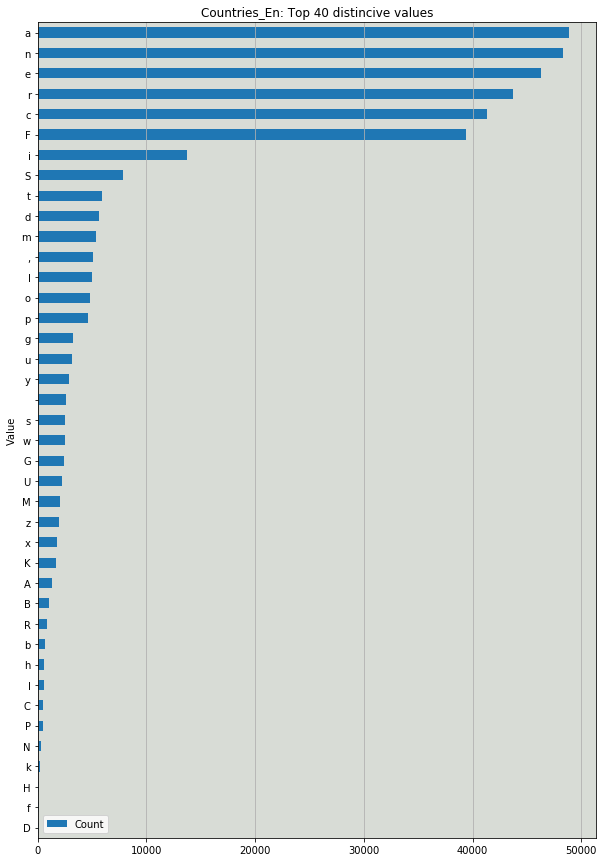

({' ',
  "'",
  ',',
  '-',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'Y',
  'Z',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'é',
  'ô',
  'ț',
  'ء',
  'ئ',
  'ا',
  'ج',
  'ر',
  'ز',
  'ص',
  'ع',
  'ل',
  'ن',
  '中',
  '国',
  '日',
  '本',
  '港',
  '香'},
 {'a': 48902,
  'q': 52,
  'j': 15,
  'x': 1769,
  '本': 1,
  'ن': 3,
  'h': 578,
  'O': 2,
  'L': 62,
  'ز': 1,
  'ô': 3,
  'ص': 3,
  't': 5908,
  'g': 3280,
  'V': 5,
  '日': 1,
  'S': 7881,
  'ر': 1,
  'ع': 3,
  'v': 81,
  'T': 95,
  'M': 1999,
  'F': 39358,
  'P': 459,
  "'": 3,
  'n': 48303,
  'e': 46278,
  'H': 147,
  '中': 1,
  'c': 41306,
  'w': 2483,
  'f': 122,
  'ل': 1,
  'C': 522,
  'é': 92,
  'Z': 59,
  'b': 678,
  'R': 802,
  'E': 86,
  's': 2490,
  'U': 2228,
  'ء'

In [17]:
_,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'countries_en')

### Labels tags

In [18]:
# Unitze labels
with open('./data/cleanse/taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(lambda x: [labels_lookup[z] for z in x.split(',')])

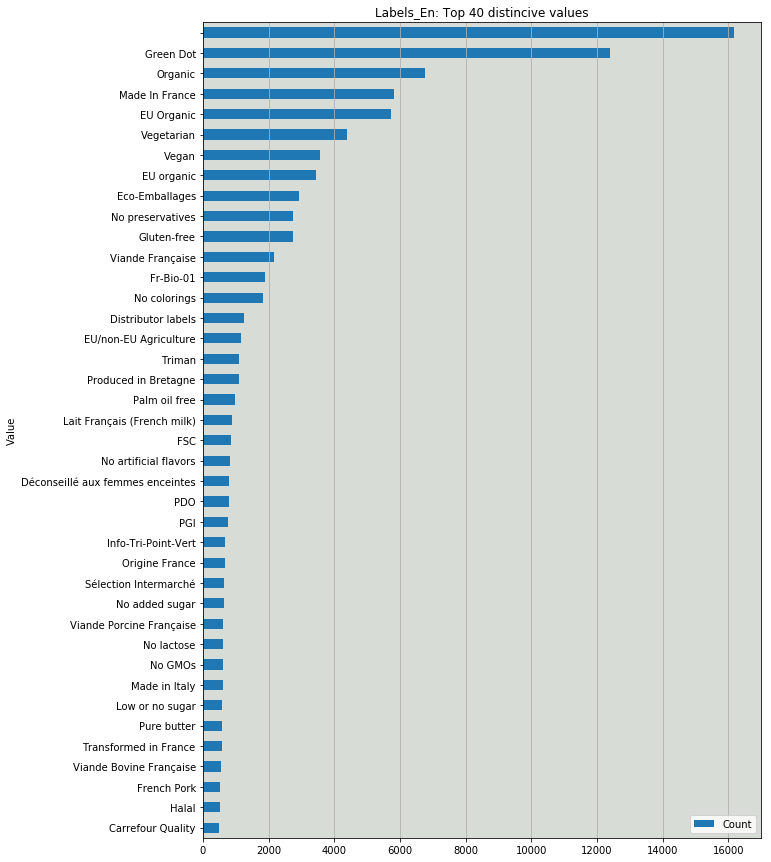

({'',
  'Glutenfrei',
  'Viande-De-Dinde-Francaise',
  'Гарантия-Качеста-От-Производителя-100-Чистый-Продукт',
  'Collecte-Et-Conditionne-En-France',
  'Feito-A-Moda-Antiga',
  'Не-Содержит-Искусственных-Ароматизаторов-Красителей-И-Консервантов',
  'Official-Sponsor-Of-The-Swedish-Olymic-Team',
  'Equitable Ecocert',
  'Es-Eco-027-Ri',
  '60-De-Cereales-Completes',
  'Fruits et Légumes de France',
  'Hazai-Termek',
  'Filiere-Directe-Producteurs-France',
  'Europaisches-Halal-Zertifizierungsinstitut',
  'Canada Organic',
  'Swiss PGI',
  'No Bisphenol-A',
  'Not-A-Sodium-Free-Food',
  'Carton-Issu-De-Forets-Geree-Durablement',
  'Moule-A-La-Main',
  'Informations-Nutritionnelles-Incorrectes-Sur-L-Emballage',
  'Agriculture-Non-Ue',
  '25-Plastique-Recycle',
  'Гост-Р-54645',
  '22-Mois-D-Affinage',
  'Без-Искусственных-Добавок',
  'Mis-En-Bouteille-En-France',
  'Fsc-C006498',
  'Знак-Відповідності-Державної-Системи-Сертифікації-Добровільна-Сертифікація',
  'Cuk-M-011',
  "Médaille D'O

In [19]:
_,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'labels_en')

### Store labels tags

In [20]:
# Unitize store labels
with open('./data/cleanse/stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("").apply(lambda x: [stores_lookup[z] for z in x.split(',')])

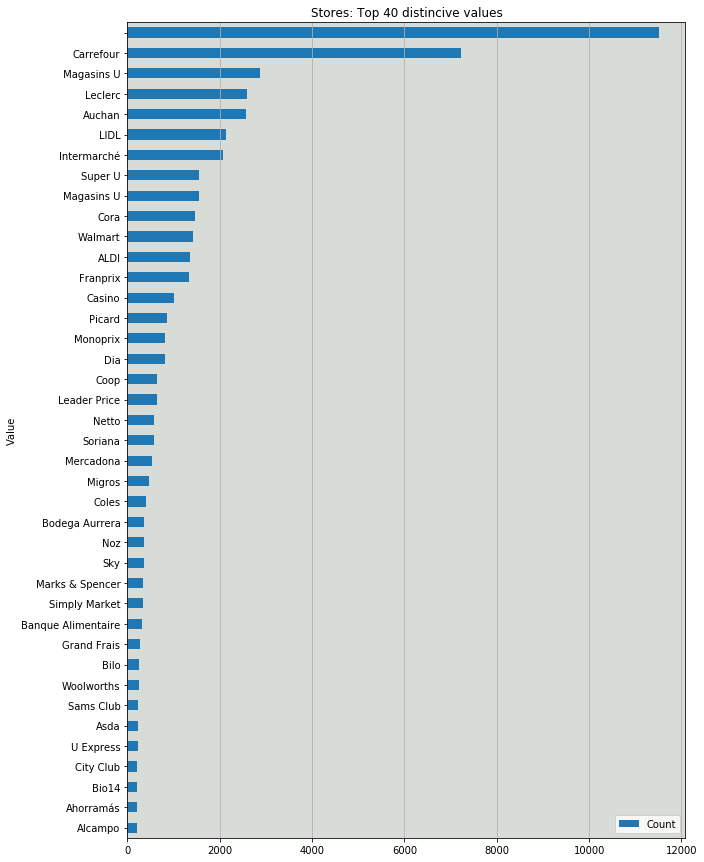

({'',
  '7 Eleven',
  'Champion Paofai',
  ' Franprix',
  'Bodega Aurrera',
  'Я Любимый',
  'Magic Pills',
  'Bon Marché',
  'Biscuiterie De Bretagne',
  'La Maison Du Bonbon',
  'Is Proxi',
  'Houra.Fr',
  'Sonda',
  'Biotope',
  'Carrefour Contact',
  'Bio Frais',
  'Rachelle Bery',
  'Trignac',
  'Belle Île',
  ' Coloquinte',
  'Le Retour A La Terre',
  'Dong Supermarket',
  'Migros Balexert',
  'Cpe',
  'Naturéobio',
  ' Lidl 42 Loire Saint Etienne',
  'Greenweez',
  'Terra Bio',
  'Mega Image',
  'Commissaries',
  'Grofers',
  'Vente Directe',
  'E-Leclerc',
  'Super Gbio',
  'Végétal & Vous',
  'Musée De La Pêche 29900 Concarneau',
  'Mercado Soriana Oxxo',
  'Domicile',
  'La Superette Bio',
  'Ica',
  'Boutique La Maison Des Abeilles',
  'Nux',
  'Pharmacie Auchan',
  'Enilv',
  'Chez Augustin',
  'Amazon.Ca',
  'Commerçant Local',
  'Gamm Vert',
  'Cereprim',
  'Alimerka',
  'Supersol',
  'Leclerc Cleunay',
  'Systeme U',
  'Le Relais Des Saveurs',
  'La Moisson - Marché Sant

In [21]:
_,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

### Food category tags

In [22]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(lambda x: x.split(','))

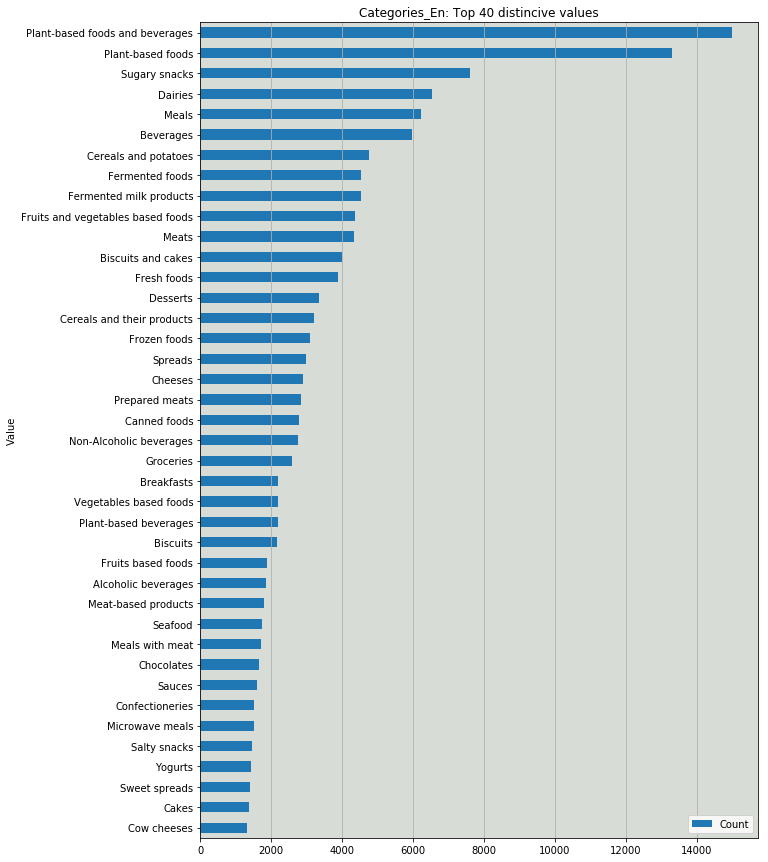

({'',
  'хлопья-гречневые',
  'Smoked-oysters-in-chilli',
  'Éclairs',
  'yaourts-musli',
  'Dried mixed mushrooms',
  'Ground steaks',
  'Oat flakes',
  'Crumble',
  'Sambuca',
  'Fried plant-based foods',
  'cereales-precocidos',
  'Artisanal spirits',
  'the-vert-menthe-bio',
  'Roquefort-cheese',
  'brote',
  'Sheepmeat meals',
  'Camemberts',
  'Saucisses de Francfort',
  'bolachas',
  'vins-de-la-communaute-europeenne',
  'Canned-beverages',
  'pan-tostaddo',
  'Strawberries-canned',
  'bouchees-de-chocolats',
  'Herbal liqueur',
  'bieres-sans-alcool',
  'Risottos aux cèpes',
  'Green curry pastes',
  'Salad-onions',
  'Fruits-et-produits-derives',
  'Caramel cheesecakes',
  'filets-de-hareng-a-l-huile-de-colza',
  'Terrines-de-campagne',
  'ab-8-monat',
  'desserts-lactes-au-bifidus',
  'truites-fumees-d-elevage',
  'cacahuetes-con-cascara-tostados-con-sal',
  'fudges',
  'Black peppers',
  'Côtes du Rhône Villages',
  'băuturi-carbogazoase',
  'pestos-a-l-ail-des-ours',
  'sau

In [23]:
_,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'categories_en')

## Carbon footprint dataset

Because the food facts database lacks carbon footprint specifications, we got random samples of products from Eaternity database. The goal afterward is to match Food Facts Database and Carbon Footprint database. First, let's take a look at the Carbon Footprint database.

### Loading the data

In [24]:
# Import data
carbon_footprint_csv_file = "./data/carbon_footprint.csv"

carbon_footprint_pd = pd.read_csv(carbon_footprint_csv_file,
                            delimiter=",")

In [25]:
carbon_footprint_pd

,ID,Title,Weight [gram/serving],CO2-Value [gram CO2/serving],CO2 rating,FAT,WATER,ENERC,PROT
0,4300175162708,K Classic - Junger Gemüsemais,100,9.0,20.812,3.480252,52.999834,765.655520,8.601195
1,4388840231829,ja! Gemüsemais,100,17.0,37.941,2.312597,35.218431,1070.401621,5.715417
2,8851613101392,Aroy-D - Kokosnussmilch,100,35.0,47.490,25.200000,33.860000,1230.000000,5.340000
3,4003994111000,Kelloggs Cornflakes Die Originalen 375 g,100,29.0,50.203,2.305610,10.145873,1458.792557,7.147392
4,4005009100542,Tortilla Chips Meersalz,100,55.0,53.102,25.168000,5.083000,1918.400000,13.321000
5,4009790005628,Meienburg Sonnenblumenkerne,100,92.0,57.100,53.000000,4.500000,2590.000000,21.300000
6,7610169013310,Migros Engagement Bio Pumpernickel,100,22.0,58.462,1.068827,45.205248,861.348421,5.344133
7,4305399028052,Naturkind - Pumpernickel,100,22.0,58.465,1.054012,44.943116,862.414698,5.318314
8,8690777653008,Sera Ajvar,100,44.0,61.076,11.526800,22.286400,1276.524000,12.058200
9,4009249020240,Lieken Urkorn – Kleines Kerni mit Sonnenblumen...,100,30.0,64.721,5.765991,45.064017,956.863493,6.286967


In [26]:
print('We have {0} ecological features for {1} products.'\
      .format(carbon_footprint_pd.shape[1], 
              carbon_footprint_pd.shape[0]))

We have 9 ecological features for 692 products.


In [27]:
carbon_footprint_pd.describe()

,ID,Weight [gram/serving],CO2-Value [gram CO2/serving],CO2 rating,FAT,WATER,ENERC,PROT
count,6.920000e+02,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000
mean,4.470674e+12,99.940751,179.528902,441.630896,10.697349,49.545595,882.731346,5.906326
std,2.198351e+12,1.558586,228.061739,461.554987,15.707044,31.501737,683.583496,6.542847
min,1.006613e+07,59.000000,8.000000,20.812000,0.000000,0.000000,0.000000,0.000000
25%,4.006025e+12,100.000000,57.000000,136.290750,0.600000,13.455100,296.250000,1.350873
50%,4.101530e+12,100.000000,97.000000,290.632500,4.366309,56.678842,717.103307,3.960000
75%,4.388844e+12,100.000000,200.000000,617.930500,14.639137,76.224948,1378.500000,8.268601
max,9.300657e+12,100.000000,2439.000000,4487.194000,89.900000,100.000000,3330.000000,86.900000


The title of each product is in german. If we want to match with the previous dataset with some keywords for exemple, we should translate into the same language. 

In [28]:
#pip install py-translate
from translate import translator

ModuleNotFoundError: No module named 'translate'

In [ ]:
def translate_row(row):
    translation = translator('de', 'en', row)

for i, row in enumerate(carbon_footprint_pd['Title']):
    print(i,row)
    carbon_footprint_pd.loc[i] = translate_row(row)


In [ ]:
ax = carbon_footprint_pd['CO2-Value [gram CO2/serving]'].hist(bins=50)
ax.set_xlabel('Carbon footprint')
ax.set_ylabel('Occurencies')
ax.set_title('Distribution of the carbon ')

## Remove non-negative entries

In [ ]:
numeric_columns = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

food_facts_pd[numeric_columns] = food_facts_pd[numeric_columns].where(food_facts_pd[numeric_columns] < 0, 0)

# Write clean data frame to CSV file

In [ ]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd

    products.to_pickle("./web_crawler/products_pd.pickle")

In [ ]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep=',', encoding='utf-8')